In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xtiff
import glob
import os
import shutil

from deepcell.applications import Mesmer
from matplotlib.colors import ListedColormap
from pathlib import Path
from skimage.segmentation import expand_labels
import sklearn

from steinbock import io
from steinbock.preprocessing import imc
from steinbock.segmentation import deepcell
from steinbock.measurement import intensities, regionprops, neighbors

import helpers

# IMC preprocessing pipeline

This pipeline will extract image data from IMC aquisitions located in the `raw` folder and generate single cell data. Intermediary steps include the extraction of image stacks selected from the panel file as well as segmentation masks. The single cell data is extracted from the chanels selected in the panel.

Before running your own script please check the [steinbock documentation](https://bodenmillergroup.github.io/steinbock).

*Installation*  
To install the required python environment, follow the instructions here: https://bodenmillergroup.github.io/steinbock/latest/install-python/

## Settings

Example data can be downloaded using the `download_examples.ipynb` script.

### Input and output directories

Folder structure:

In [10]:
dataset_dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria"
base_dir = Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20220723_Steinbock_Mesmer_IFbased")

raw_dir = base_dir / "raw"

# Output directories
img_dir = base_dir / "img"
masks_dir = base_dir / "masks"
segstack_dir = base_dir / "segstacks"
intensities_dir = base_dir / "intensities"
regionprops_dir = base_dir / "regionprops"
neighbors_dir = base_dir / "neighbors"

# Create directories (if they do not already exist)
img_dir.mkdir(exist_ok=True)
masks_dir.mkdir(exist_ok=True)
segstack_dir.mkdir(exist_ok=True)
intensities_dir.mkdir(exist_ok=True)
regionprops_dir.mkdir(exist_ok=True)
neighbors_dir.mkdir(exist_ok=True)

## Extract `.mcd` files

In [ ]:
'''samples = pd.read_csv(base_dir / "samples_to_keep.csv", header=None)


for s in samples[0].values: 
    src_mcd_path = glob.glob(dataset_dir + '/*{}*'.format(s) + '/**/*.[mM][cC][dD]')[0]
    shutil.copy(src_mcd_path, img_dir)

#Remove masks of RoI that had a cell shift in order to be able to compare it to IF-based segmentation and single-cell data
dir = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20220723_Steinbock_Mesmer_IMCbased/img"

samples = pd.read_csv(base_dir / "samples_to_keep_roi_exclude.csv", sep=';')

for index, row in samples.iterrows():
    if not pd.isnull(row['ROI_exclude']):
        for r in (row['ROI_exclude'].split(',')):
            if int(r) < 10:
                roi_name = '00' + r
            else:
                roi_name = '0' + r
            file_to_remove = glob.glob(dir + '/*{}*{}*'.format(row['Sample'],roi_name))[0]
            os.remove(file_to_remove)
'''


## Extract images from `.mcd` files

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/preprocessing/#external-images

### Import the panel
The antibody panel should meet the steinbock format: https://bodenmillergroup.github.io/steinbock/latest/file-types/#panel  

An example panel corresponding to the example data (downloadable via the `download_examples.ipynb` script is provided.

Customized panels should contain the following columns:
+ `channel`: unique channel id, typically metal and isotope mass (e.g. `Ir191`)
+ `name`: unique channel name.
+ `deepcell`: channels to use for segmentation (1=nuclear, 2=membrane, empty/NaN=ignored).
+ `keep`: *(optional)* 1 for channels to preprocess, 0 for channels to ignore

In [11]:
imc_panel = pd.read_csv(base_dir / "NB_panel.csv", sep=',')

if "keep" in imc_panel.columns:
    imc_panel = imc_panel[imc_panel["keep"]==1]
imc_panel.head()

,name,channel,keep,deepcell
0,Myeloperoxidase MPO,Y89,1,NaN
1,CD44,In115,1,2.0
2,131Xe,Xe131,1,NaN
3,134Xe,Xe134,1,NaN
4,136Ba,Ba136,1,NaN


### Unzip

zip folders should contain one `.mcd` file and all the associated `.txt` files.

In [ ]:
# Extract .mcd files
helpers.extract_zips(path=raw_dir, suffix=".mcd", dest=raw_dir)

In [ ]:
# Extract .txt files
helpers.extract_zips(path=raw_dir, suffix=".txt", dest=raw_dir)

### Convert to tiff

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/preprocessing/#image-conversion

#### Settings
Image stacks are extracted from the acquisitions in `.tiff` format.

In [ ]:
extract_metadata = True

# Value for hot pixel filtering (see the documentation)
hpf = 50

#### Image conversion
Extract image stacks from IMC acquisitions (stored in the `img` subfolder) and export metadata as `images.csv`.

In [ ]:
image_info_data = pd.DataFrame()

for mcd_file, acquisition, img, matched_txt, recovered in imc.try_preprocess_images_from_disk(
    mcd_files = imc.list_mcd_files(raw_dir),
    txt_files = imc.list_txt_files(raw_dir),
    hpf = hpf,
    channel_names = imc_panel["channel"]
):
    img_file = Path(img_dir) / f"{mcd_file.stem}_{acquisition.description}.tiff"
    io.write_image(img, img_file)

    if extract_metadata :
        image_info = helpers.extract_metadata(img_file, mcd_file, img, acquisition, matched_txt, recovered)
        image_info_data = pd.concat([image_info_data, image_info])
        
if extract_metadata:
    image_info_data.to_csv(base_dir / "images.csv", index=False)

## Cell segmentation

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/segmentation/#deepcell  

### Prepare segmentation stacks

Segmentation stacks are generated by aggregating the channels selcted in `panel.csv` in the column `deepcell`. 
Cell segmentation requires to construct as 2-channel images with the following structure:
+ Channel 1 = nuclear channels
+ Channel 2 = cytoplasmic/membranous channels.

For channel-wise normalization, zscore and min-max methods are available.  
In addition, different functions can be used to aggregate channels. Default: `np.mean`, for other options, see https://numpy.org/doc/stable/reference/routines.statistics.html#averages-and-variances.

In [ ]:
# Define image preprocessing options
channelwise_zscore = True
channelwise_minmax = False
aggr_func = np.sum

# Define channels to use for segmentation (from the panel file)
channel_groups = imc_panel["deepcell"].values
channel_groups = np.where(channel_groups == 0, np.nan, channel_groups) # make sure unselected chanels are set to nan

#### Generate segmentation stacks

In [ ]:
x=0
for img_path in sorted(Path(img_dir).glob("*.tiff")):
    img = io.read_image(img_path)
    if channelwise_minmax:
        img = helpers.norm_minmax(img)
    
    if channelwise_zscore:
        img = helpers.norm_zscore(img)
    
    if channel_groups is not None:
        img = helpers.segstack_channels(img, channel_groups, aggr_func)
    
    img_file = Path(segstack_dir) / f"{img_path.name}"
    io.write_image(img, img_file)

#### Check segmentation stacks

Text(0.5, 1.0, '20220224_07-3302_BM_R_ROI_001: membrane')

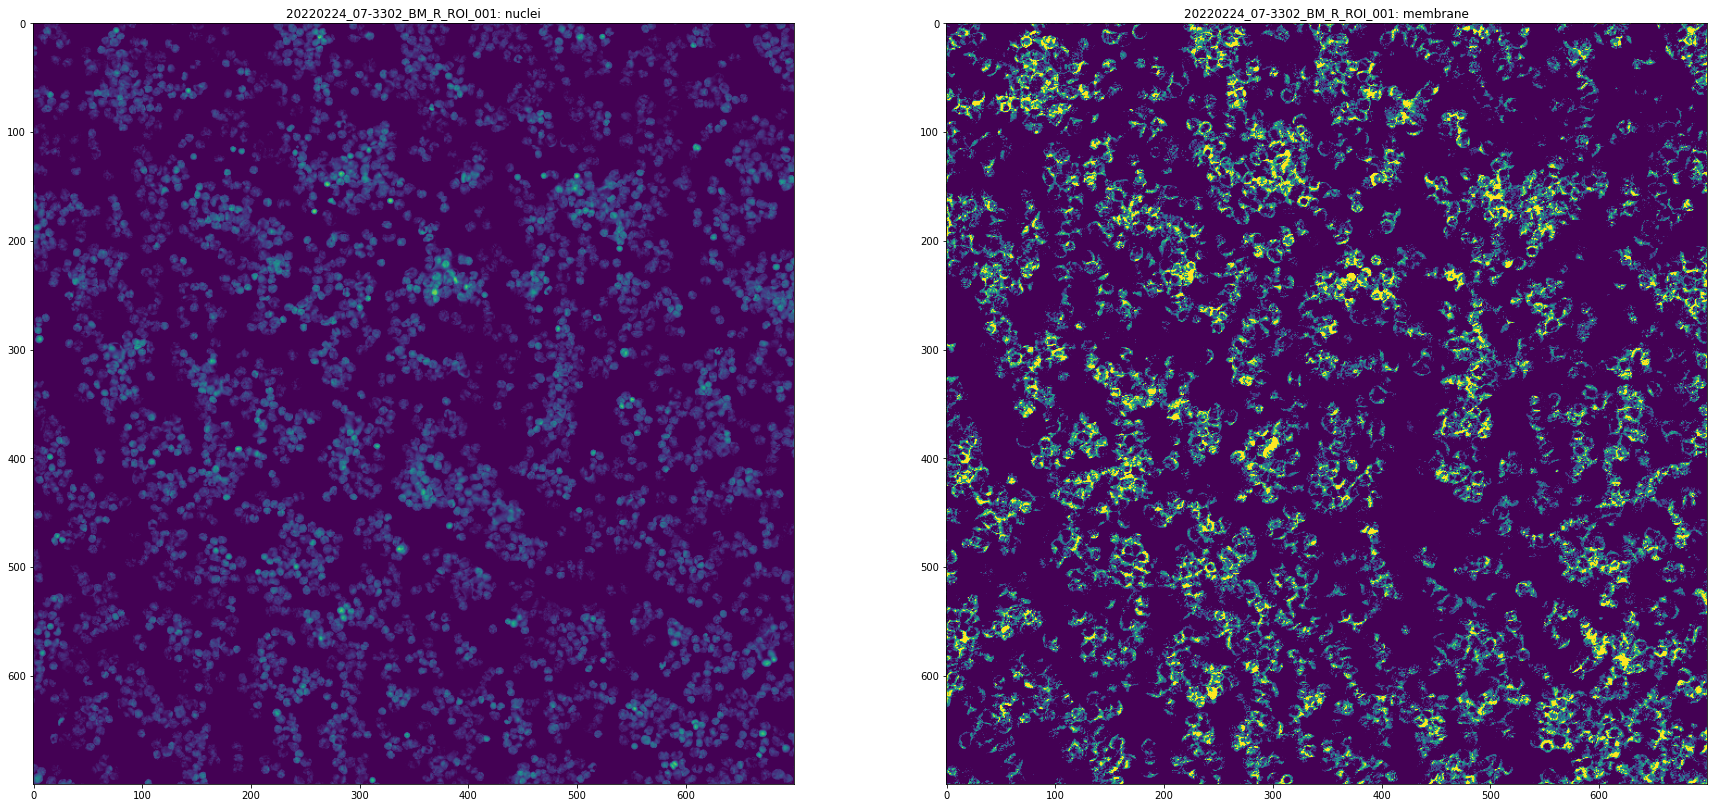

In [12]:
# List segmentation stacks
segstacks = sorted(Path(segstack_dir).glob("*.tiff"))

# Select a random image
rng = np.random.default_rng()
ix = rng.choice(len(segstacks))

# Display nuclear and membrane/cytoplasm images
fig, ax = plt.subplots(1, 2, figsize=(30, 30))

img = io.read_image(segstacks[ix])
ax[0].imshow(img[0,:,:], vmin=0, vmax=8) # adjust vmax if needed (lower value = higher intensity)
ax[0].set_title(segstacks[ix].stem + ": nuclei")

img = io.read_image(segstacks[ix])
ax[1].imshow(img[1,:,:], vmin=0, vmax=8) # adjust vmax if needed (lower value = higher intensity)
ax[1].set_title(segstacks[ix].stem + ": membrane")

### Segment cells

`segmentation_type` should be one of [`whole-cell`, `nuclear`, `both`].  
If `both` is selected, nuclear and whole-cell masks will be generated in separate subfolders.  

Several post-processing arguments can be passed to the deepcell application, the defaults are selected below. Cell labels can also be expanded by defining an `expansion_distance` (mostly useful for nuclear segmentation).

In [13]:
# Segmentation type
segmentation_type = "nuclear"

# Post-processing arguments for whole-cell segmentation
kwargs_whole_cell =  {
    'maxima_threshold': 0.075,
    'maxima_smooth': 0,
    'interior_threshold': 0.2,
    'interior_smooth': 2,
    'small_objects_threshold': 15,
    'fill_holes_threshold': 15,
    'radius': 2
}

# Post-processing arguments for nuclear segmentation
kwargs_nuclear =  {
    'maxima_threshold': 0.1,
    'maxima_smooth': 0,
    'interior_threshold': 0.2,
    'interior_smooth': 2,
    'small_objects_threshold': 15,
    'fill_holes_threshold': 15,
    'radius': 2
}

# Mask pixel expansion (0 = no expansion)
expansion_distance = 0

In [ ]:
app = Mesmer()

for stack in segstacks:
    img = io.read_image(stack)
    img = np.moveaxis(img, 0, 2)
    img = np.expand_dims(img.data, 0)
    
    mask = app.predict(
        img, image_mpp=1, compartment=segmentation_type,
        postprocess_kwargs_whole_cell=kwargs_whole_cell,
        postprocess_kwargs_nuclear=kwargs_nuclear
    )
    
    helpers.save_masks(
        mask, masks_dir, stack.name,
        segmentation_type, expansion_distance
    )

In [ ]:
# # Generating masks using steinbock's function
# for img_path, mask in deepcell.try_segment_objects(
#     img_files = segstacks,
#     application = deepcell.Application.MESMER,
#     pixel_size_um = 1.0,
#     segmentation_type = segmentation_type
# ):
#     mask = expand_labels(mask, distance=float(expansion_distance))
    
#     mask_file = Path(masks_subdir) / f"{img_path.stem}.tiff"
#     io.write_mask(mask, mask_file)

#### Check segmentation

Adjust the image intensity by modifiying the `max_intensity` variable.  
For higher magnification images, adjust the coordinates and dimension if needed.

In [14]:
# Choose either 'nuclear' or 'whole-cell' for downstream processing
segmentation_type = "nuclear"


(400.0, 500.0)

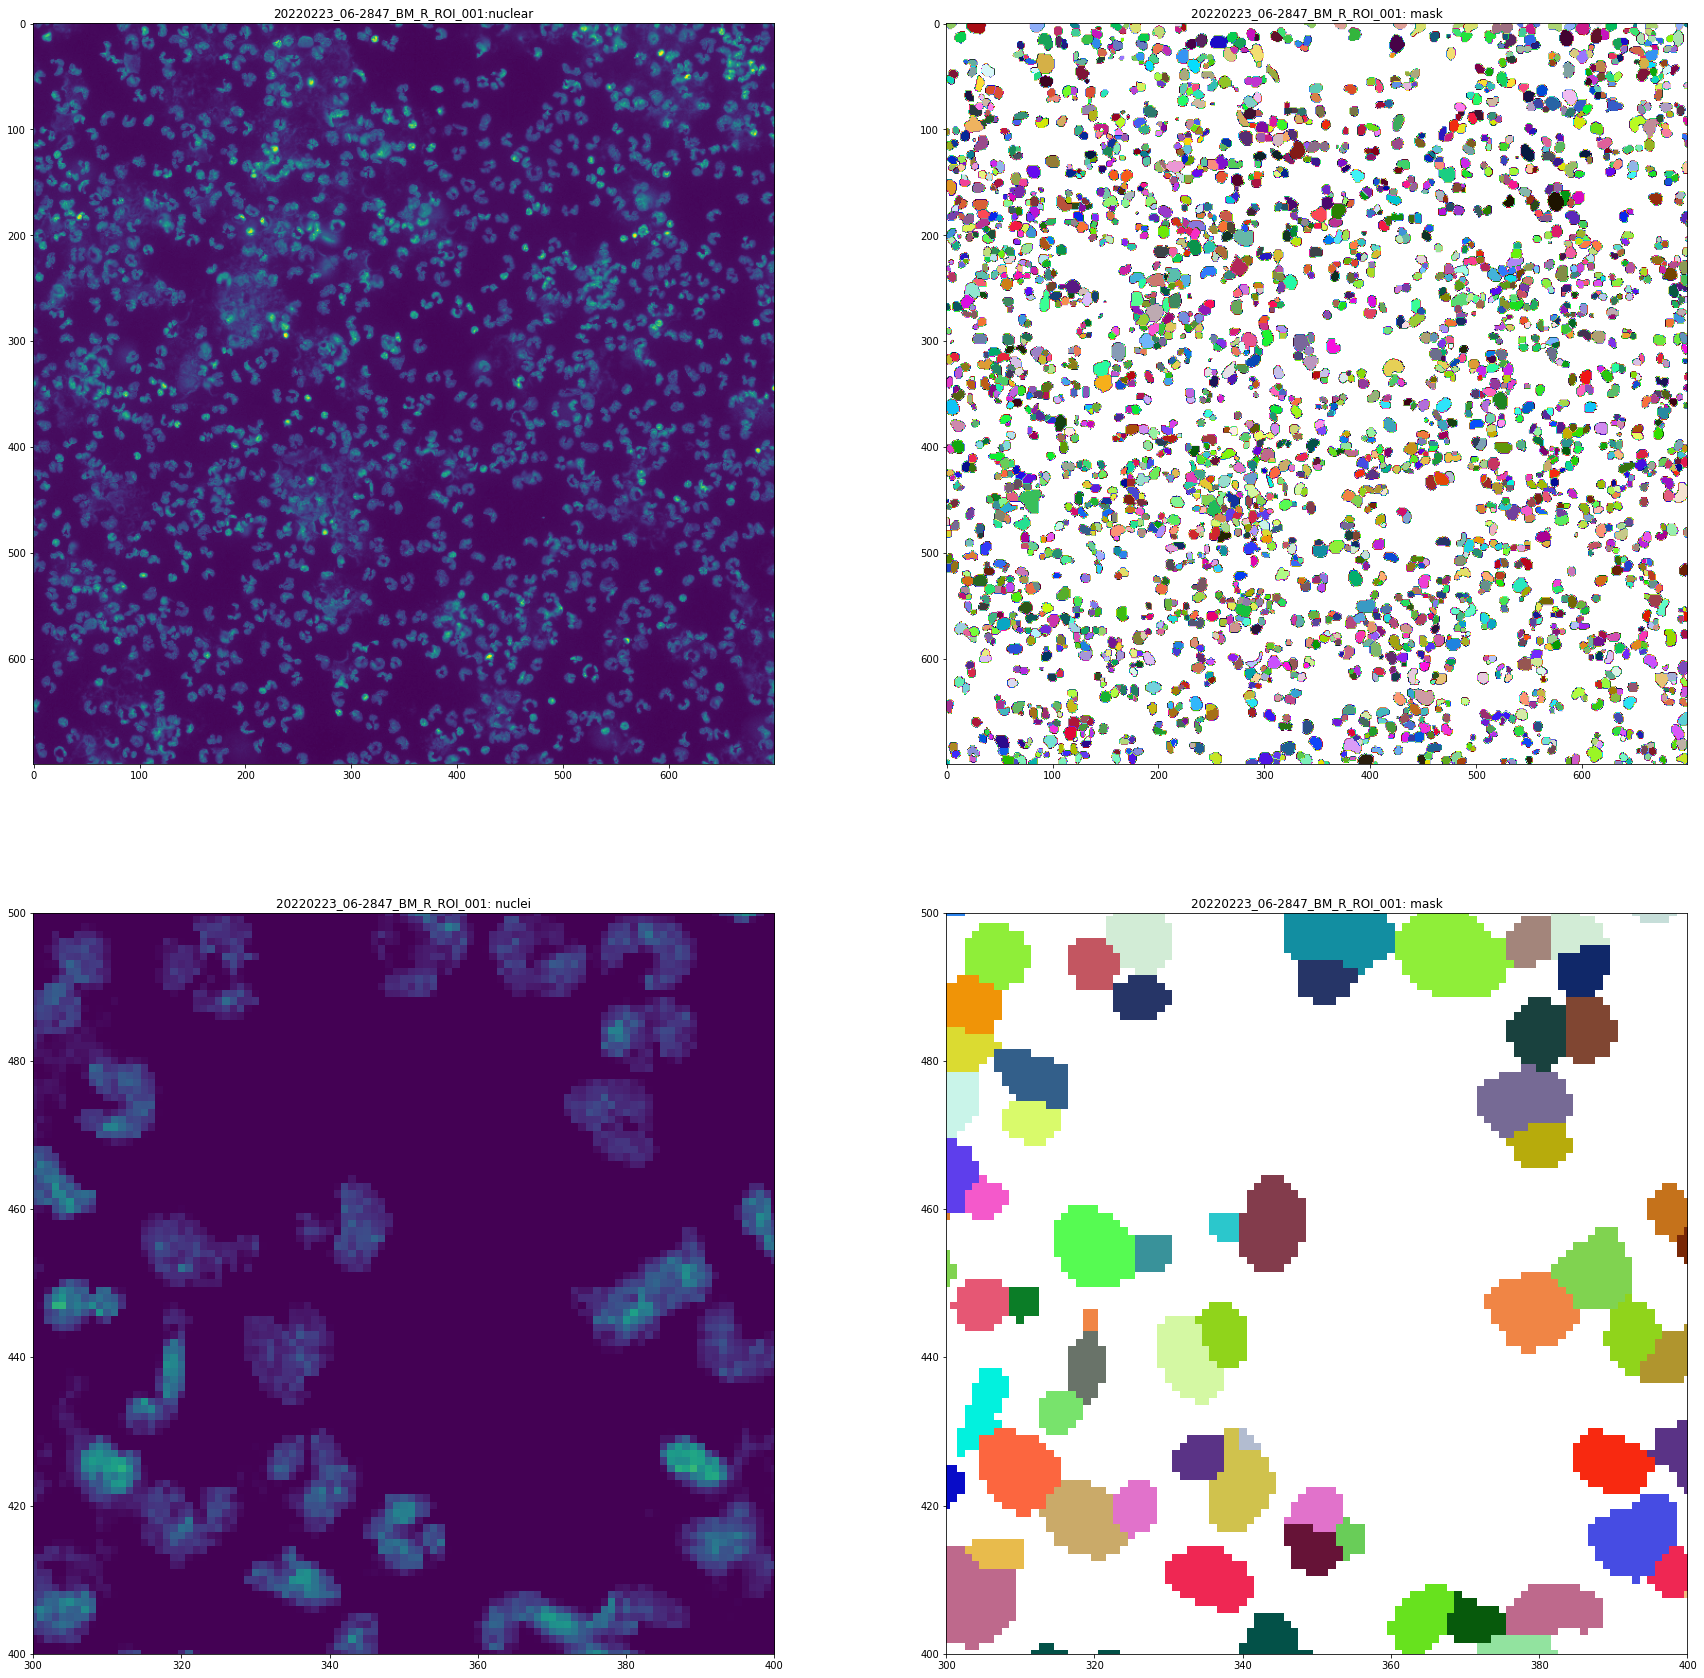

In [15]:
# List masks
masks_subdir = masks_dir / segmentation_type
masks = sorted(Path(masks_subdir).glob("*.tiff"))

# Define instensity value for images
max_intensity = 8 # vmax: lower values = higher intensity

# Select a random image
ix = rng.choice(len(masks))
fig, ax = plt.subplots(2, 2, figsize=(30, 30))

# Display image and mask
img = io.read_image(segstacks[ix])
ax[0,0].imshow(img[0,:,:], vmax=max_intensity)
ax[0,0].set_title(segstacks[ix].stem + ":" + segmentation_type)

mask = io.read_image(masks[ix])
cmap = ListedColormap(np.random.rand(10**3,3))
cmap.colors[0]=[1,1,1]
ax[0,1].imshow(mask[0,:,:], cmap=cmap)
ax[0,1].set_title(masks[ix].stem +": mask")

## Higher magnification (change coordinates and dimensions if needed)
xstart = 300
ystart = 400
dim = 100

ax[1,0].imshow(img[0,:,:], vmin=0, vmax=max_intensity) 
ax[1,0].set_title(segstacks[ix].stem + ": nuclei")
ax[1,0].set_xlim([xstart, xstart+dim])
ax[1,0].set_ylim([ystart, ystart+dim])

ax[1,1].imshow(mask[0,:,:], cmap=cmap)
ax[1,1].set_title(masks[ix].stem +": mask")
ax[1,1].set_xlim([xstart, xstart+dim])
ax[1,1].set_ylim([ystart, ystart+dim])

## Measure cells

### Measure cell intensities per channel

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/measurement/#object-intensities

In [ ]:
for img_path, mask_path, intens in intensities.try_measure_intensities_from_disk(
    img_files = io.list_image_files(img_dir),
    mask_files = io.list_image_files(masks_subdir),
    channel_names = imc_panel["name"],
    intensity_aggregation = intensities.IntensityAggregation.MEAN
):
    intensities_file = Path(intensities_dir) / f"{img_path.name.replace('.tiff', '.csv')}"
    pd.DataFrame.to_csv(intens, intensities_file)

In [ ]:
intens.columns

### Measure cell spatial properties

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/measurement/#region-properties

#### List properties to measure

For a full list of measurable properties, refer to https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [ ]:
skimage_regionprops = [
        "area",
        "centroid",
        "major_axis_length",
        "minor_axis_length",
        "eccentricity",
    ]

#### Measure region props

In [ ]:
for img_path, mask_path, region_props in regionprops.try_measure_regionprops_from_disk(
    img_files = io.list_image_files(img_dir),
    mask_files = io.list_image_files(masks_subdir),
    skimage_regionprops = skimage_regionprops
):
    
    regionprops_file = Path(regionprops_dir) / f"{img_path.name.replace('.tiff', '.csv')}"
    pd.DataFrame.to_csv(region_props, regionprops_file)

### Measure cell neighbors

Documentation: https://bodenmillergroup.github.io/steinbock/latest/cli/measurement/#object-neighbors

#### Settings

*Neighborhood types:*
+ `NeighborhoodType.CENTROID_DISTANCE`
+ `NeighborhoodType.EUCLIDEAN_BORDER_DISTANCE`
+ `NeighborhoodType.EUCLIDEAN_PIXEL_EXPANSION`

*Thresholding:*
+ `dmax` (max distance between centroids)
+ `kmax` (k-nearest neighbors)

In [ ]:
neighborhood_type = neighbors.NeighborhoodType.CENTROID_DISTANCE
dmax = 15
kmax = 5

#### Measure cell neighbors

In [ ]:
for mask_path, neighb in neighbors.try_measure_neighbors_from_disk(
    mask_files = io.list_image_files(masks_subdir),
    neighborhood_type = neighborhood_type,
    metric = "euclidean",
    dmax = dmax,
    kmax = kmax
):
    neighb_file = Path(neighbors_dir) / f"{mask_path.name.replace('.tiff', '.csv')}"
    pd.DataFrame.to_csv(neighb, neighb_file, index=False)

In [ ]:
!conda list